In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.rcParams.update({'font.size': 9})

/tmp/ipykernel_3527562/496717171.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


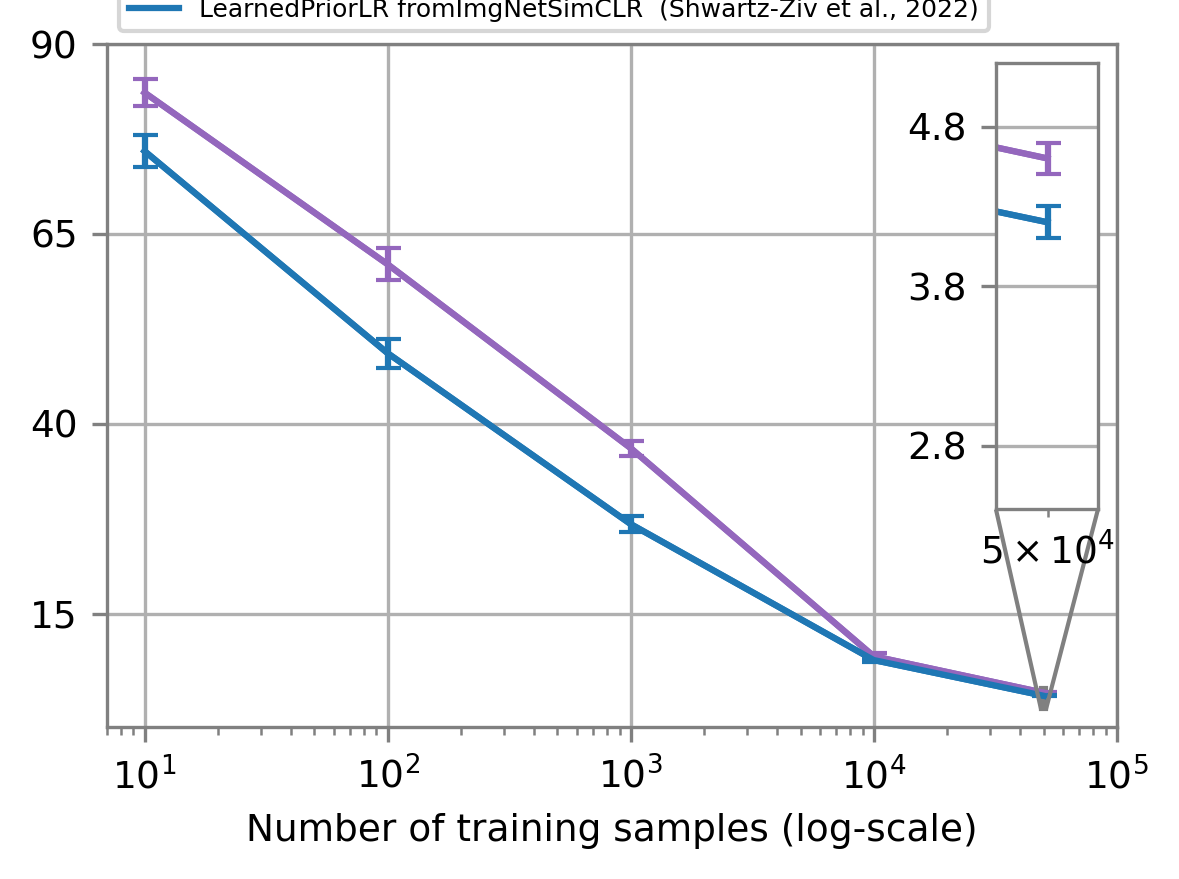

In [2]:
def color_ax(ax, color='gray'):
    ax.grid(zorder=0)
    ax.spines['bottom'].set_color(color)
    ax.spines['top'].set_color(color)
    ax.spines['left'].set_color(color)
    ax.spines['right'].set_color(color)
    ax.tick_params(which='both', color=color)

def plot_figure_4a(ax):    
    # Reported values in Pre-Train Your Loss
    #ax.plot([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], label='StdPrior fromImgNetSuper (Kaplun et al., 2023)', color='#2ca02c')
    #ax.errorbar([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], yerr=[5.2, 1.22, 0.34, 0.07], capsize=3, color='#2ca02c')
    #ax.plot([10, 100, 1000, 10000, 50000], [81.9, 62.1, 36.5, 11.6, 4.4], label='StdPrior fromImgNetSuper (Shwartz-Ziv et al., 2022)', color='#ff7f0e')
    ax.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], label='StdPrior fromImgNetSimCLR  (Shwartz-Ziv et al., 2022)', color='#9467bd')
    ax.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    ax.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], label='LearnedPriorLR fromImgNetSimCLR  (Shwartz-Ziv et al., 2022)', color='#1f77b4')
    ax.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    # Zoomed section
    axins = zoomed_inset_axes(ax, zoom=21, loc='upper right')
    #axins.plot([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], color='#2ca02c')
    #axins.errorbar([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], yerr=[5.2, 1.22, 3.4, 0.07], capsize=3, color='#2ca02c')
    #axins.plot([10, 100, 1000, 10000, 50000], [81.9, 62.1, 36.5, 11.6, 4.4], color='#ff7f0e')
    axins.plot([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], color='#9467bd')
    axins.errorbar([10, 100, 1000, 10000, 50000], [83.6, 61.0, 36.8, 9.4, 4.6], yerr=[1.8, 2.1, 1.0, 0.4, 0.1], capsize=3, color='#9467bd')
    axins.plot([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], color='#1f77b4')
    axins.errorbar([10, 100, 1000, 10000, 50000], [75.9, 49.3, 26.8, 8.9, 4.2], yerr=[2.1, 1.9, 1.1, 0.3, 0.1], capsize=3, color='#1f77b4')
    axins.set_xlim([48850, 51150])
    axins.set_ylim([2.4, 5.2])
    axins.set_yticks([2.8, 3.8, 4.8])
    axins.set_xscale('log')
    color_ax(axins)
    axins.set_xticks([50000], minor=True)
    mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
    # Formatting
    ax.set_xlim([7, 1e5])
    ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
    ax.set_yticks([15, 40, 65, 90])
    ax.set_xscale('log')
    color_ax(ax)
    ax.set_xlabel('Number of training samples (log-scale)')
    #ax.set_ylabel('Test error')
    legend = ax.legend(loc='lower left', bbox_to_anchor=(0, 1), fontsize=6)
    legend.set_in_layout(False)
    return legend
    
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
legend = plot_figure_4a(ax)
fig.tight_layout()
#plt.savefig('supervised_comparison.pdf', bbox_inches='tight', bbox_extra_artists=(legend,))
plt.show()

In [3]:
def get_df(path):
    df = pd.read_csv(path, index_col='Unnamed: 0')
    return df

def get_val_nll(df):
    return df.val_or_test_nll.values[-1]

def get_val_acc1(df):
    if 'val_or_test_acc' in df.columns:
        return df.val_or_test_acc.values[-1]
    elif 'val_or_test_acc1' in df.columns:
        return df.val_or_test_acc1.values[-1]

In [4]:
def get_best_hyperparams(
    bb_weight_decays, 
    clf_weight_decays, 
    experiments_path, # Gets best hyperparameters from experiments_path
    lr_0s, 
    ns, 
    prior_type, # Gets best hyperparameters for a single prior_type
    random_states, 
    weight_decays
):
    hyperparam_names = ['bb_weight_decay', 'clf_weight_decay', 'lr_0', 'n', 'random_state', 'weight_decay']
    columns = ['model_name', 'n', 'prior_type', 'random_state', 'val_acc1', 'val_nll']
    df = pd.DataFrame(columns=columns)
    
    for hyperparams in itertools.product(bb_weight_decays, clf_weight_decays, lr_0s, ns, random_states, weight_decays):
        model_name = f'{prior_type}_' + '_'.join(f'{hyperparam_name}={hyperparam}' for hyperparam_name, hyperparam in zip(hyperparam_names, hyperparams) if hyperparam is not None)
        bb_weight_decay, clf_weight_decay, lr_0, n, random_state, weight_decay = hyperparams
        if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
            print(model_name)
            pass
        else:
            temp_df = get_df(f'{experiments_path}/{model_name}.csv')
            val_acc1 = get_val_acc1(temp_df)
            val_nll = get_val_nll(temp_df)
            df.loc[df.shape[0]] = [model_name, n, prior_type, random_state, val_acc1, val_nll]
                    
    min_indices = df.groupby(['n', 'random_state'])['val_nll'].idxmin()
    df = df.loc[min_indices].reset_index(drop=True)
    #max_indices = df.groupby(['n', 'random_state'])['val_acc1'].idxmax()
    #df = df.loc[max_indices].reset_index(drop=True)
                    
    return df

def get_results(
    df,
    experiments_path
):
    columns = ['model_name', 'n', 'prior_type', 'random_state', 'test_acc1', 'test_nll']
    results_df = pd.DataFrame(columns=columns)
    
    for row_index, row in df.iterrows():
        model_name = row.model_name
        prior_type, n, random_state = row.prior_type, row.n, row.random_state
        if not os.path.exists(f'{experiments_path}/{model_name}.csv'):
            #print(model_name)
            pass
        else:
            temp_df = get_df(f'{experiments_path}/{model_name}.csv')
            test_acc1 = get_val_acc1(temp_df)
            test_nll = get_val_nll(temp_df)
            condition = (results_df['n']==n)&(results_df['random_state']==random_state)
            if len(results_df[condition]) == 0:
                results_df.loc[results_df.shape[0]] = [model_name, n, prior_type, random_state, test_acc1, test_nll]
    
    return results_df

In [5]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [10, 100, 1000, 10000, 50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'nonlearned'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_CIFAR-10'
weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]

std_prior = get_best_hyperparams([None], [None], experiments_path, lr_0s, ns, prior_type, random_states, weight_decays)
std_prior

,model_name,n,prior_type,random_state,val_acc1,val_nll
0,nonlearned_lr_0=0.01_n=10_random_state=1001_we...,10,nonlearned,1001,0.0000,2.826736
1,nonlearned_lr_0=0.0001_n=10_random_state=2001_...,10,nonlearned,2001,0.0000,3.600672
2,nonlearned_lr_0=0.001_n=10_random_state=3001_w...,10,nonlearned,3001,0.0000,2.696253
3,nonlearned_lr_0=0.01_n=100_random_state=1001_w...,100,nonlearned,1001,0.7000,0.951838
4,nonlearned_lr_0=0.001_n=100_random_state=2001_...,100,nonlearned,2001,0.5000,1.355964
5,nonlearned_lr_0=0.001_n=100_random_state=3001_...,100,nonlearned,3001,0.6500,0.983005
6,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,0.7550,0.670592
7,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,0.8200,0.803543
8,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,0.8650,0.434508
9,nonlearned_lr_0=0.01_n=10000_random_state=1001...,10000,nonlearned,1001,0.9265,0.262783


In [6]:
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [10, 100, 1000, 10000, 50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'adapted'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_CIFAR-10'
weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]

learned_prior_iso = get_best_hyperparams([None], [None], experiments_path, lr_0s, ns, prior_type, random_states, weight_decays)
learned_prior_iso

,model_name,n,prior_type,random_state,val_acc1,val_nll
0,adapted_lr_0=0.1_n=10_random_state=1001_weight...,10,adapted,1001,0.0000,2.377469
1,adapted_lr_0=0.1_n=10_random_state=2001_weight...,10,adapted,2001,0.0000,2.474465
2,adapted_lr_0=0.1_n=10_random_state=3001_weight...,10,adapted,3001,0.0000,2.341610
3,adapted_lr_0=0.001_n=100_random_state=1001_wei...,100,adapted,1001,0.7000,0.983326
4,adapted_lr_0=0.001_n=100_random_state=2001_wei...,100,adapted,2001,0.5000,1.374754
5,adapted_lr_0=0.001_n=100_random_state=3001_wei...,100,adapted,3001,0.6500,0.972365
6,adapted_lr_0=0.1_n=1000_random_state=1001_weig...,1000,adapted,1001,0.8350,0.523390
7,adapted_lr_0=0.1_n=1000_random_state=2001_weig...,1000,adapted,2001,0.8150,0.667335
8,adapted_lr_0=0.01_n=1000_random_state=3001_wei...,1000,adapted,3001,0.9100,0.392827
9,adapted_lr_0=0.1_n=10000_random_state=1001_wei...,10000,adapted,1001,0.9335,0.199625


In [7]:
bb_weight_decays = np.logspace(0, 9, num=10)
clf_weight_decays = [0.01, 0.001, 0.0001, 1e-05, 1e-06, 0.0]
dataset_path = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/tuned_CIFAR-10'
lr_0s = [0.1, 0.01, 0.001, 0.0001]
ns = [10, 100, 1000, 10000, 50000]
prior_path = '/cluster/tufts/hugheslab/eharve06/resnet50_ssl_prior'
prior_type = 'LearnedPriorLR'
random_states = [1001, 2001, 3001]
wandb_project = 'tuned_CIFAR-10'

learned_prior_lr = get_best_hyperparams(bb_weight_decays, clf_weight_decays, experiments_path, lr_0s, ns, prior_type, random_states, [None])
learned_prior_lr

,model_name,n,prior_type,random_state,val_acc1,val_nll
0,LearnedPriorLR_bb_weight_decay=1000000.0_clf_w...,10,LearnedPriorLR,1001,0.000000,2.511933
1,LearnedPriorLR_bb_weight_decay=1000000.0_clf_w...,10,LearnedPriorLR,2001,0.000000,2.973418
2,LearnedPriorLR_bb_weight_decay=10000000.0_clf_...,10,LearnedPriorLR,3001,0.000000,2.329212
3,LearnedPriorLR_bb_weight_decay=100000.0_clf_we...,100,LearnedPriorLR,1001,60.000000,1.021263
4,LearnedPriorLR_bb_weight_decay=1.0_clf_weight_...,100,LearnedPriorLR,2001,75.000000,0.906630
5,LearnedPriorLR_bb_weight_decay=1000000.0_clf_w...,100,LearnedPriorLR,3001,70.000000,0.967850
6,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,1001,0.875000,0.436516
7,LearnedPriorLR_bb_weight_decay=100.0_clf_weigh...,1000,LearnedPriorLR,2001,82.999999,0.609634
8,LearnedPriorLR_bb_weight_decay=10.0_clf_weight...,1000,LearnedPriorLR,3001,89.499999,0.299455
9,LearnedPriorLR_bb_weight_decay=10.0_clf_weight...,10000,LearnedPriorLR,1001,93.250000,0.228510


In [8]:
experiments_path = '/cluster/tufts/hugheslab/eharve06/bdl-transfer-learning/experiments/retrained_CIFAR-10'
std_prior_results = get_results(std_prior, experiments_path)
learned_prior_iso_results = get_results(learned_prior_iso, experiments_path)
learned_prior_lr_results = get_results(learned_prior_lr, experiments_path)
results = pd.concat([std_prior_results, learned_prior_iso_results, learned_prior_lr_results])
results

,model_name,n,prior_type,random_state,test_acc1,test_nll
0,nonlearned_lr_0=0.01_n=10_random_state=1001_we...,10,nonlearned,1001,0.1317,3.200835
1,nonlearned_lr_0=0.0001_n=10_random_state=2001_...,10,nonlearned,2001,0.2621,2.097741
2,nonlearned_lr_0=0.001_n=10_random_state=3001_w...,10,nonlearned,3001,0.2669,2.124110
3,nonlearned_lr_0=0.01_n=100_random_state=1001_w...,100,nonlearned,1001,0.5301,1.753938
4,nonlearned_lr_0=0.001_n=100_random_state=2001_...,100,nonlearned,2001,0.5987,1.273124
5,nonlearned_lr_0=0.001_n=100_random_state=3001_...,100,nonlearned,3001,0.5575,1.404902
6,nonlearned_lr_0=0.0001_n=1000_random_state=100...,1000,nonlearned,1001,0.7818,0.689700
7,nonlearned_lr_0=0.01_n=1000_random_state=2001_...,1000,nonlearned,2001,0.8181,0.790316
8,nonlearned_lr_0=0.01_n=1000_random_state=3001_...,1000,nonlearned,3001,0.8275,0.655546
9,nonlearned_lr_0=0.01_n=10000_random_state=1001...,10000,nonlearned,1001,0.9372,0.226423


In [9]:
grouped_results = results.groupby(['n', 'prior_type']).agg(lambda x: tuple(x))
columns = ['test_acc1', 'test_nll']
for column in columns:
    grouped_results[f'{column}_mean'] = grouped_results[column].apply(lambda item: np.mean(item))
    grouped_results[f'{column}_std'] = grouped_results[column].apply(lambda item: np.std(item))
    grouped_results[f'{column}_min'] = grouped_results[column].apply(lambda item: np.min(item))
    grouped_results[f'{column}_max'] = grouped_results[column].apply(lambda item: np.max(item))
grouped_results = grouped_results.reset_index()
grouped_results

,n,prior_type,model_name,random_state,test_acc1,test_nll,test_acc1_mean,test_acc1_std,test_acc1_min,test_acc1_max,test_nll_mean,test_nll_std,test_nll_min,test_nll_max
0,10,LearnedPriorLR,(LearnedPriorLR_bb_weight_decay=1000000.0_clf_...,"(1001, 2001, 3001)","(17.080000000000002, 18.83, 11.250000000000004)","(2.303623052215577, 2.3892940402984637, 3.3865...",15.720000,3.240504,11.2500,18.8300,2.693154,0.491547,2.303623,3.386544
1,10,adapted,(adapted_lr_0=0.1_n=10_random_state=1001_weigh...,"(1001, 2001, 3001)","(0.2339000254869461, 0.175599992275238, 0.2116...","(2.244244303131104, 2.346000033950806, 2.32525...",0.207067,0.024025,0.1756,0.2339,2.305165,0.043903,2.244244,2.346000
2,10,nonlearned,(nonlearned_lr_0=0.01_n=10_random_state=1001_w...,"(1001, 2001, 3001)","(0.1316999942064285, 0.2621000111103058, 0.266...","(3.200834867477418, 2.0977412963867184, 2.1241...",0.220233,0.062633,0.1317,0.2669,2.474229,0.513901,2.097741,3.200835
3,100,LearnedPriorLR,(LearnedPriorLR_bb_weight_decay=100000.0_clf_w...,"(1001, 2001, 3001)","(56.400000000000006, 59.00000000000001, 56.400...","(1.439711721801758, 1.2922731227874755, 1.4419...",57.266667,1.225652,56.4000,59.0000,1.391326,0.070047,1.292273,1.441993
4,100,adapted,(adapted_lr_0=0.001_n=100_random_state=1001_we...,"(1001, 2001, 3001)","(0.5476000308990479, 0.5982000231742859, 0.555...","(1.4966200017929077, 1.3010373809814455, 1.406...",0.567267,0.022140,0.5476,0.5982,1.401535,0.079938,1.301037,1.496620
5,100,nonlearned,(nonlearned_lr_0=0.01_n=100_random_state=1001_...,"(1001, 2001, 3001)","(0.5300999879837036, 0.5986999869346619, 0.557...","(1.7539382343292234, 1.2731240596771238, 1.404...",0.562100,0.028194,0.5301,0.5987,1.477322,0.202861,1.273124,1.753938
6,1000,LearnedPriorLR,(LearnedPriorLR_bb_weight_decay=100.0_clf_weig...,"(1001, 2001, 3001)","(83.86000000000003, 83.26000000000002, 83.4699...","(0.5820776025295256, 0.5649791242122649, 0.578...",83.530000,0.248596,83.2600,83.8600,0.575300,0.007416,0.564979,0.582078
7,1000,adapted,(adapted_lr_0=0.1_n=1000_random_state=1001_wei...,"(1001, 2001, 3001)","(0.8163000345230103, 0.820099949836731, 0.8209...","(0.6228910679817198, 0.6203525841712954, 0.782...",0.819133,0.002037,0.8163,0.8210,0.675372,0.076022,0.620353,0.782873
8,1000,nonlearned,(nonlearned_lr_0=0.0001_n=1000_random_state=10...,"(1001, 2001, 3001)","(0.7818000316619873, 0.8181000351905823, 0.827...","(0.6896996079444885, 0.7903160516738894, 0.655...",0.809133,0.019705,0.7818,0.8275,0.711854,0.057206,0.655546,0.790316
9,10000,LearnedPriorLR,(LearnedPriorLR_bb_weight_decay=10.0_clf_weigh...,"(1001, 2001, 3001)","(94.07000000000002, 93.37999999999998, 93.9099...","(0.2186949087619782, 0.231239442539215, 0.2095...",93.786667,0.294882,93.3800,94.0700,0.219824,0.008895,0.209538,0.231239


/tmp/ipykernel_3527562/1317911178.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


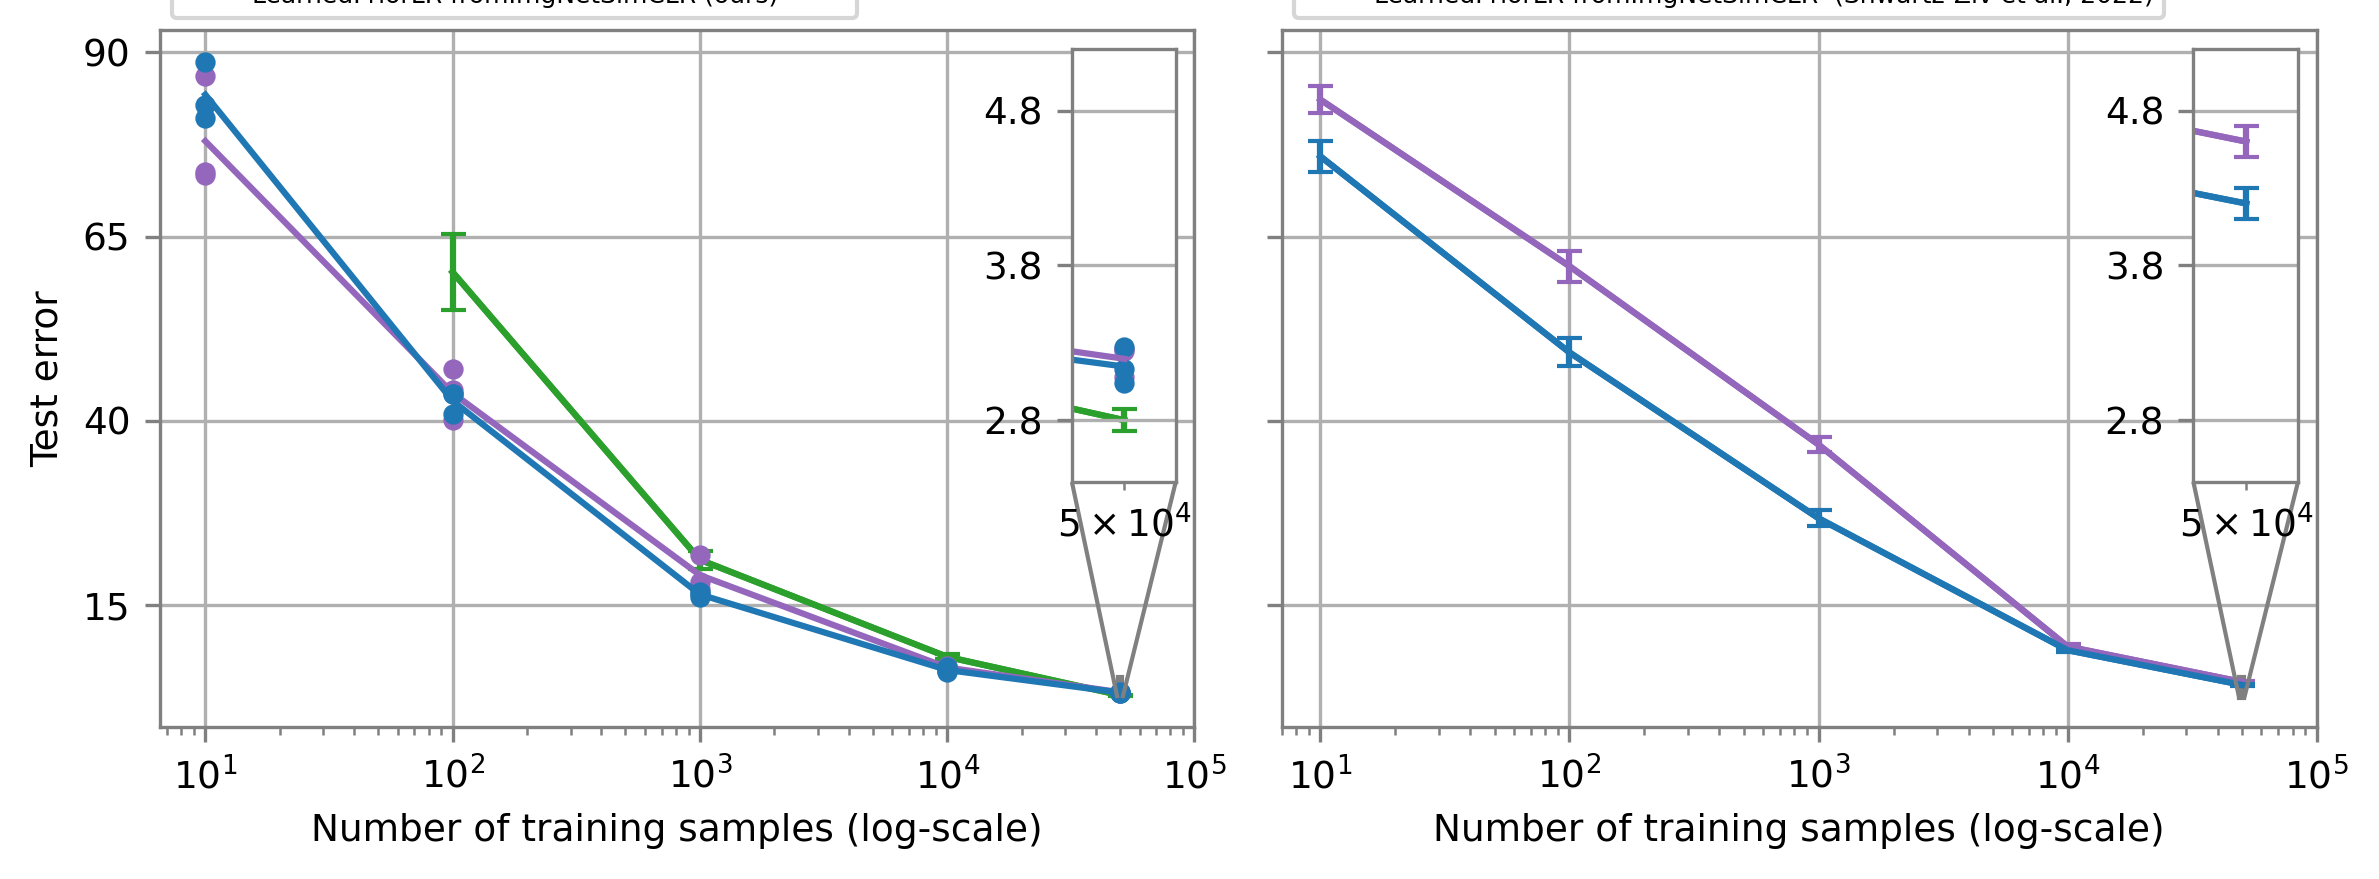

In [10]:
ncols, nrows = 2, 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 3*nrows), sharey=True, dpi=300)
axs[0].plot([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], label='StdPrior fromImgNetSuper (Kaplun et al., 2023)', color='#2ca02c', zorder=2)
axs[0].errorbar([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], yerr=[5.2, 1.22, 0.34, 0.07], capsize=3, color='#2ca02c', zorder=2)
axs[0].plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc1_mean.values), label='StdPrior fromImgNetSimCLR (ours)', color='#9467bd', zorder=3)
axs[0].scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc1.values), color='#9467bd', s=15, zorder=3)
axs[0].plot(grouped_results[grouped_results.prior_type=='LearnedPriorLR'].n, (100-grouped_results[grouped_results.prior_type=='LearnedPriorLR'].test_acc1_mean.values), label='LearnedPriorLR fromImgNetSimCLR (ours)', color='#1f77b4', zorder=4)
axs[0].scatter(results[results.prior_type=='LearnedPriorLR'].n, (100-results[results.prior_type=='LearnedPriorLR'].test_acc1.values), color='#1f77b4', s=15, zorder=4)
# Zoomed section
axins = zoomed_inset_axes(axs[0], zoom=21, loc='upper right')
axins.plot([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], color='#2ca02c', zorder=0)
axins.errorbar([100, 1000, 10000, 50000], [60.2, 21.17, 8, 2.8], yerr=[5.2, 1.22, 0.34, 0.07], capsize=3, color='#2ca02c', zorder=0)
axins.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc1_mean.values), color='#9467bd')
axins.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc1.values), color='#9467bd', s=15)
axins.plot(grouped_results[grouped_results.prior_type=='LearnedPriorLR'].n, (100-grouped_results[grouped_results.prior_type=='LearnedPriorLR'].test_acc1_mean.values), color='#1f77b4')
axins.scatter(results[results.prior_type=='LearnedPriorLR'].n, (100-results[results.prior_type=='LearnedPriorLR'].test_acc1.values), color='#1f77b4', s=15)
axins.set_xlim([48850, 51150])
axins.set_ylim([2.4, 5.2])
axins.set_yticks([2.8, 3.8, 4.8])
axins.set_xscale('log')
color_ax(axins)
axins.set_xticks([50000], minor=True)
mark_inset(axs[0], axins, loc1=3, loc2=4, color='gray')
# Formatting
axs[0].set_xscale('log')
color_ax(axs[0])
axs[0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
axs[0].set_yticks([15, 40, 65, 90])
axs[0].set_xlabel('Number of training samples (log-scale)')
axs[0].set_ylabel('Test error')
legend1 = axs[0].legend(loc='lower left', bbox_to_anchor=(0, 1), fontsize=6)
legend1.set_in_layout(False)
legend2 = plot_figure_4a(axs[1])
fig.tight_layout()
plt.savefig('replication.pdf', bbox_inches='tight', bbox_extra_artists=(legend1, legend2))
plt.show()

/tmp/ipykernel_3527562/3886535369.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


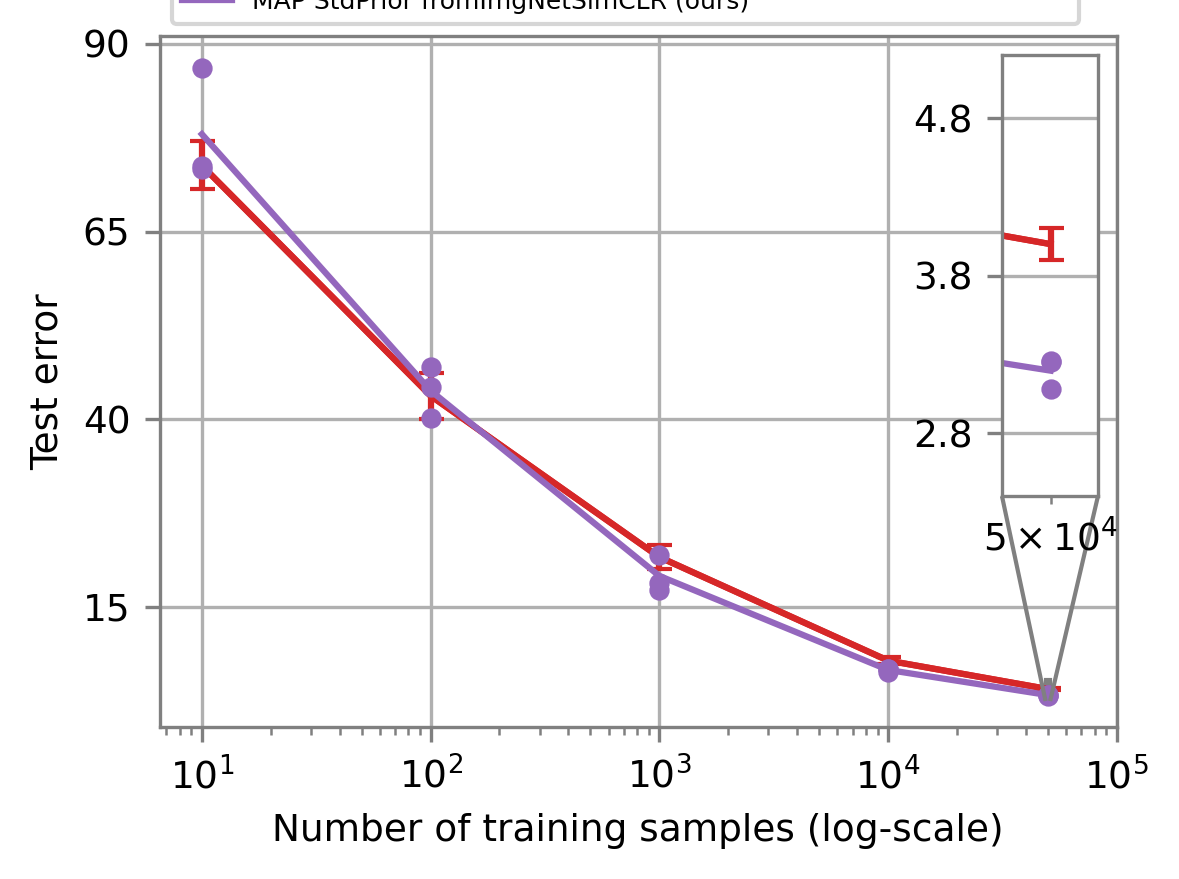

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 3), dpi=300)
ax.plot([10, 100, 1000, 10000, 50000], [73.8, 43.1, 21.6, 7.8, 4.0], label='FullBayes LearnedPriorLR fromImgNetSimCLR (Shwartz-Ziv et al.,\n2022)', color='#d62728', zorder=2)
ax.errorbar([10, 100, 1000, 10000, 50000], [73.8, 43.1, 21.6, 7.8, 4.0], yerr=[3.2, 3.1, 1.6, 0.5, 0.1], capsize=3, color='#d62728', zorder=2)
ax.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc1_mean.values), label='MAP StdPrior fromImgNetSimCLR (ours)', color='#9467bd', zorder=3)
ax.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc1.values), color='#9467bd', s=15, zorder=3)
# Zoomed section
axins = zoomed_inset_axes(ax, zoom=21, loc='upper right')
axins.plot([10, 100, 1000, 10000, 50000], [73.8, 43.1, 21.6, 7.8, 4.0], color='#d62728', zorder=0)
axins.errorbar([10, 100, 1000, 10000, 50000], [73.8, 43.1, 21.6, 7.8, 4.0], yerr=[3.2, 3.1, 1.6, 0.5, 0.1], capsize=3, color='#d62728', zorder=0)
axins.plot(grouped_results[grouped_results.prior_type=='nonlearned'].n, 100*(1-grouped_results[grouped_results.prior_type=='nonlearned'].test_acc1_mean.values), color='#9467bd')
axins.scatter(results[results.prior_type=='nonlearned'].n, 100*(1-results[results.prior_type=='nonlearned'].test_acc1.values), color='#9467bd', s=15)
axins.set_xlim([48850, 51150])
axins.set_ylim([2.4, 5.2])
axins.set_yticks([2.8, 3.8, 4.8])
axins.set_xscale('log')
color_ax(axins)
axins.set_xticks([50000], minor=True)
mark_inset(ax, axins, loc1=3, loc2=4, color='gray')
# Formatting
ax.set_xscale('log')
color_ax(ax)
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks([15, 40, 65, 90])
ax.set_xlabel('Number of training samples (log-scale)')
ax.set_ylabel('Test error')
legend = ax.legend(loc='lower left', bbox_to_anchor=(0, 1), fontsize=6)
legend.set_in_layout(False)
fig.tight_layout()
plt.savefig('Bayesian_comparison.pdf', bbox_inches='tight', bbox_extra_artists=(legend,))
plt.show()